In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt

import pytensor
from pytensor.tensor.optimize import minimize
from pymc_extras.inference.inla import *

from pymc.model.fgraph import fgraph_from_model, model_from_fgraph
# from pymc_extras.model.marginal.marginal_model import marginalize

In [3]:
def marginalize(
    model,
    rvs_to_marginalize,
    Q,
    temp_kwargs,
    minimizer_kwargs={"method": "BFGS", "optimizer_kwargs": {"tol": 1e-8}},
):
    from pymc.model.fgraph import (
        ModelFreeRV,
        ModelValuedVar,
    )

    from pymc_extras.model.marginal.graph_analysis import (
        find_conditional_dependent_rvs,
        find_conditional_input_rvs,
        is_conditional_dependent,
        subgraph_batch_dim_connection,
    )

    from pymc_extras.model.marginal.marginal_model import (
        _unique,
        collect_shared_vars,
        remove_model_vars,
    )

    from pymc_extras.model.marginal.distributions import (
        MarginalLaplaceRV,
    )

    from pymc.pytensorf import collect_default_updates

    from pytensor.graph import (
        FunctionGraph,
        Variable,
        clone_replace,
    )

    fg, memo = fgraph_from_model(model)
    rvs_to_marginalize = [memo[rv] for rv in rvs_to_marginalize]
    toposort = fg.toposort()

    for rv_to_marginalize in sorted(
        rvs_to_marginalize,
        key=lambda rv: toposort.index(rv.owner),
        reverse=True,
    ):
        all_rvs = [node.out for node in fg.toposort() if isinstance(node.op, ModelValuedVar)]

        dependent_rvs = find_conditional_dependent_rvs(rv_to_marginalize, all_rvs)
        if not dependent_rvs:
            # TODO: This should at most be a warning, not an error
            raise ValueError(f"No RVs depend on marginalized RV {rv_to_marginalize}")

        # Issue warning for IntervalTransform on dependent RVs
        for dependent_rv in dependent_rvs:
            transform = dependent_rv.owner.op.transform

            # if isinstance(transform, IntervalTransform) or (
            #     isinstance(transform, Chain)
            #     and any(isinstance(tr, IntervalTransform) for tr in transform.transform_list)
            # ):
            #     warnings.warn(
            #         f"The transform {transform} for the variable {dependent_rv}, which depends on the "
            #         f"marginalized {rv_to_marginalize} may no longer work if bounds depended on other variables.",
            #         UserWarning,
            #     )

        # Check that no deterministics or potentials depend on the rv to marginalize
        for det in model.deterministics:
            if is_conditional_dependent(memo[det], rv_to_marginalize, all_rvs):
                raise NotImplementedError(
                    f"Cannot marginalize {rv_to_marginalize} due to dependent Deterministic {det}"
                )
        for pot in model.potentials:
            if is_conditional_dependent(memo[pot], rv_to_marginalize, all_rvs):
                raise NotImplementedError(
                    f"Cannot marginalize {rv_to_marginalize} due to dependent Potential {pot}"
                )

        marginalized_rv_input_rvs = find_conditional_input_rvs([rv_to_marginalize], all_rvs)
        other_direct_rv_ancestors = [
            rv
            for rv in find_conditional_input_rvs(dependent_rvs, all_rvs)
            if rv is not rv_to_marginalize
        ]
        input_rvs = _unique((*marginalized_rv_input_rvs, *other_direct_rv_ancestors))

        output_rvs = [rv_to_marginalize, *dependent_rvs]
        rng_updates = collect_default_updates(output_rvs, inputs=input_rvs, must_be_shared=False)
        outputs = output_rvs + list(rng_updates.values())
        inputs = input_rvs + list(rng_updates.keys())
        # Add any other shared variable inputs
        inputs += collect_shared_vars(output_rvs, blockers=inputs)

        inner_inputs = [inp.clone() for inp in inputs]
        inner_outputs = clone_replace(outputs, replace=dict(zip(inputs, inner_inputs)))
        inner_outputs = remove_model_vars(inner_outputs)

        marginalize_constructor = MarginalLaplaceRV

        _, _, *dims = rv_to_marginalize.owner.inputs
        marginalization_op = marginalize_constructor(
            inputs=inner_inputs,
            outputs=inner_outputs,
            dims_connections=[
                (None,),
            ],  # dependent_rvs_dim_connections, # TODO NOT SURE WHAT THIS IS
            dims=dims,
            Q=Q,
            temp_kwargs=temp_kwargs,
            minimizer_kwargs=minimizer_kwargs,
        )

        new_outputs = marginalization_op(*inputs)
        for old_output, new_output in zip(outputs, new_outputs):
            new_output.name = old_output.name

        model_replacements = []
        for old_output, new_output in zip(outputs, new_outputs):
            if old_output is rv_to_marginalize or not isinstance(
                old_output.owner.op, ModelValuedVar
            ):
                # Replace the marginalized ModelFreeRV (or non model-variables) themselves
                var_to_replace = old_output
            else:
                # Replace the underlying RV, keeping the same value, transform and dims
                var_to_replace = old_output.owner.inputs[0]
            model_replacements.append((var_to_replace, new_output))

        fg.replace_all(model_replacements)

    return model_from_fgraph(fg, mutate_fgraph=True)

In [ ]:
# - Will need to figure out how to get p(x | y)
# - dims_connections

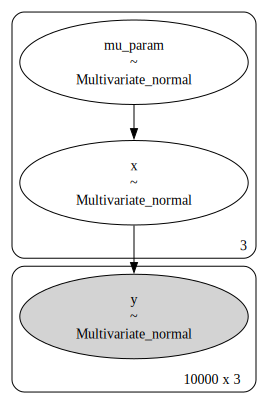

In [4]:
rng = np.random.default_rng(12345)
n = 10000
d = 3

mu_mu = np.zeros((d,))
mu_true = np.ones((d,))

cov = np.diag(np.ones(d))
Q_val = np.diag(np.ones(d))
cov_true = np.diag(np.ones(d))

with pm.Model() as model:
    x_mu = pm.MvNormal("mu_param", mu=mu_mu, cov=cov)

    x = pm.MvNormal("x", mu=x_mu, tau=Q_val)

    y_obs = rng.multivariate_normal(mean=mu_true, cov=cov_true, size=n)

    y = pm.MvNormal(
        "y",
        mu=x,
        cov=cov,  # cov_param.reshape((d, d)),
        observed=y_obs,
    )

pm.model_to_graphviz(model)

[0. 0. 0.]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu_param]
>Metropolis: [x]


Output()

/home/michaln/git/pymc/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/michaln/git/pymc/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/michaln/git/pymc/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'mu_param\n0'}>,
        <Axes: title={'center': 'mu_param\n1'}>,
        <Axes: title={'center': 'mu_param\n2'}>],
       [<Axes: title={'center': 'x\n0'}>,
        <Axes: title={'center': 'x\n1'}>,
        <Axes: title={'center': 'x\n2'}>]], dtype=object)

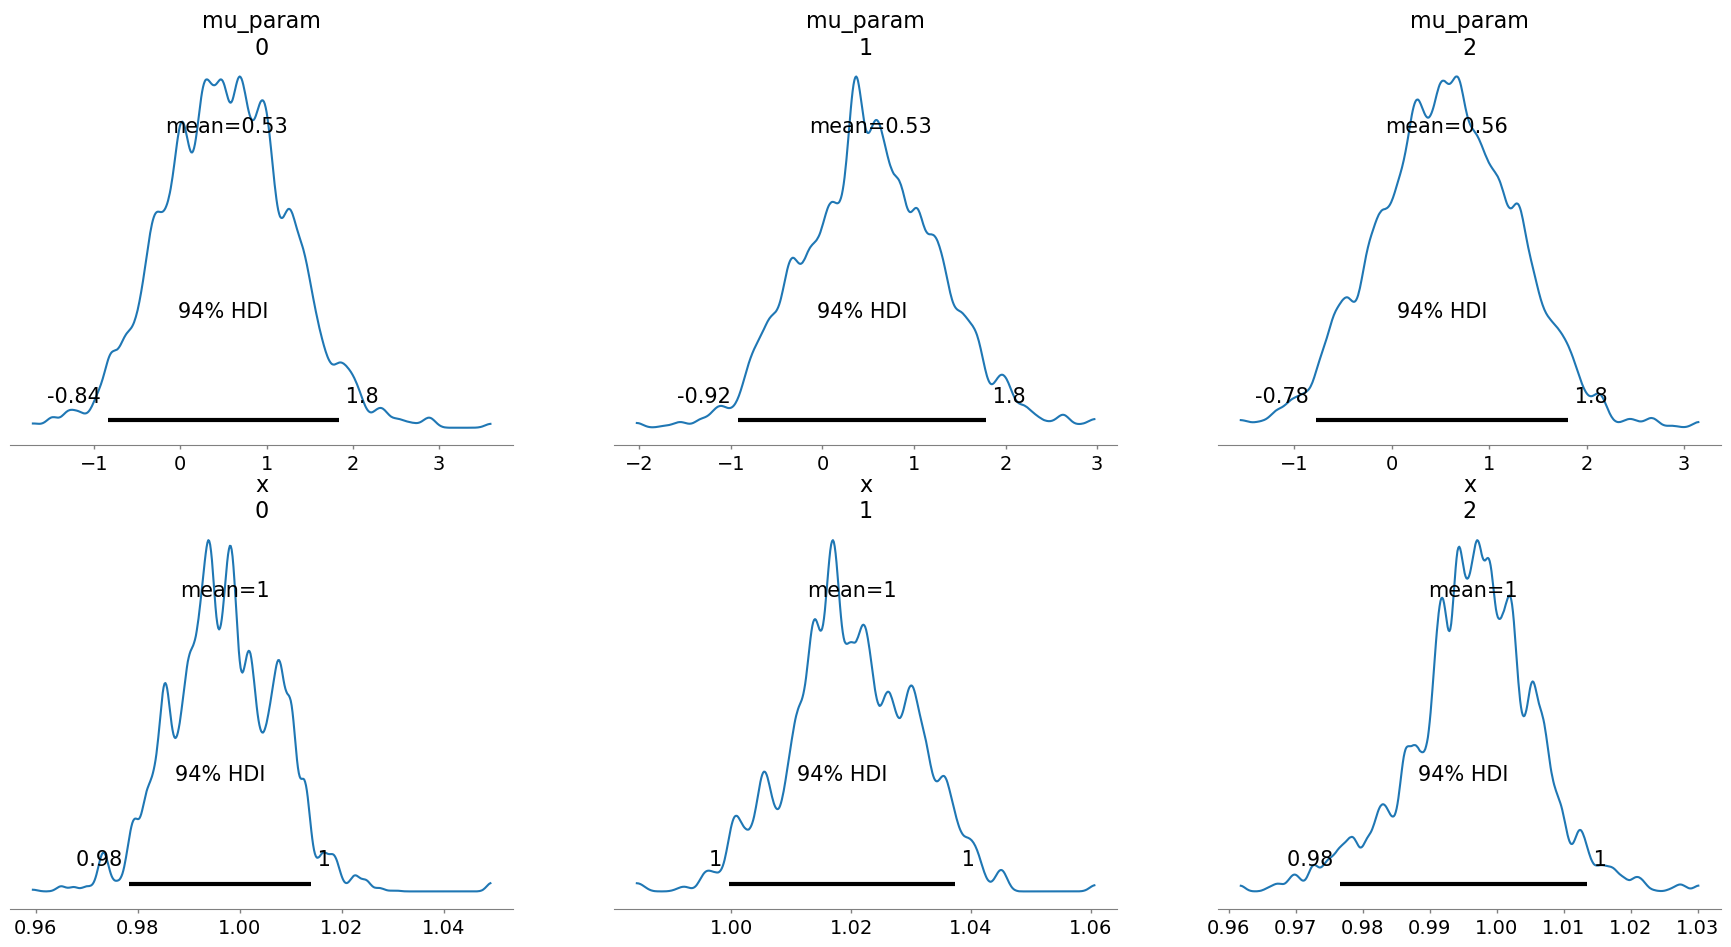

In [22]:
print(mu_mu)

with model as m:
    idata = pm.sample()

az.plot_posterior(idata)

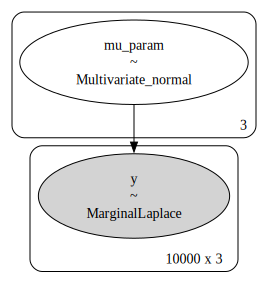

In [14]:
model_marg = marginalize(
    model,
    [x],
    Q=Q_val,
    temp_kwargs=None,
    minimizer_kwargs={"method": "L-BFGS-B", "optimizer_kwargs": {"tol": 1e-8}},
)
pm.model_to_graphviz(model_marg, var_names=["y"])

In [15]:
rng = np.random.default_rng(12345)
mu = rng.random(d)

f_logp = model_marg.compile_logp(profile=True)

In [16]:
%%timeit
f_logp({"mu_param": mu})

11.4 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
f_logp.f.profile.summary()

Function profiling
  Message: /home/michaln/git/pymc/pymc/pytensorf.py:942
  Time in 811 calls to Function.__call__: 7.526662e+00s
  Time in Function.vm.__call__: 7.505440152948722s (99.718%)
  Time in thunks: 7.487781524658203s (99.483%)
  Total compilation time: 2.368786e+00s
    Number of Apply nodes: 29
    PyTensor rewrite time: 1.740722e+00s
       PyTensor validate time: 6.187005e-03s
    PyTensor Linker time (includes C, CUDA code generation/compiling): 0.6244314390060026s
       C-cache preloading 3.356296e-03s
       Import time 4.223835e-02s
       Node make_thunk time 6.202545e-01s
           Node MinimizeOp(method=L-BFGS-B, jac=True, hess=False, hessp=False)([0.2273360 ... .79736546], True, [0.], [[2]], [[[1. 0. 0 ... . 0. 1.]]], [0.5], True, 0.0, [[2]], ExpandDims{axis=0}.0, [[[1. 0. 0 ... . 0. 1.]]]) time 5.042768e-01s
           Node Scan{scan_fn, while_loop=False, inplace=none}(3, [0 1 2], 3, Neg.0, Neg.0) time 8.727831e-02s
           Node CAReduce{Composite{(i0 + sqr

[0. 0. 0.]


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu_param]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


array([<Axes: title={'center': 'mu_param\n0'}>,
       <Axes: title={'center': 'mu_param\n1'}>,
       <Axes: title={'center': 'mu_param\n2'}>], dtype=object)

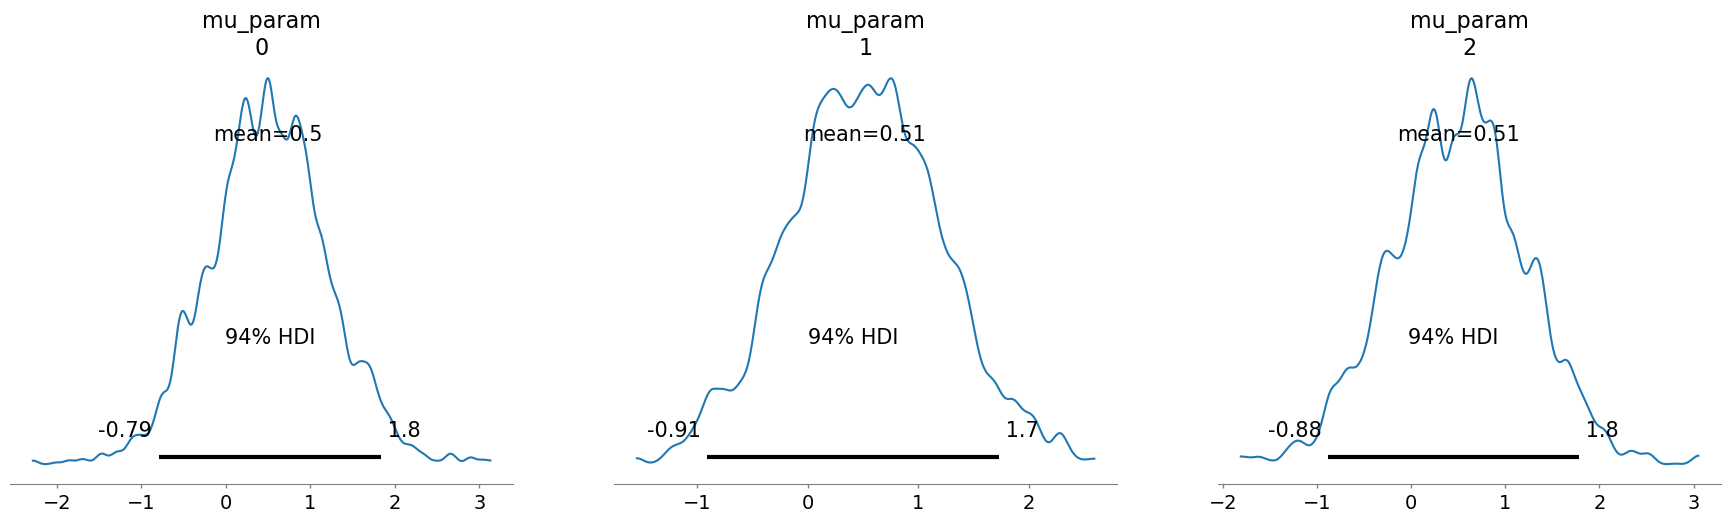

In [21]:
print(mu_mu)

with model_marg as m:
    idata_marg = pm.sample()

az.plot_posterior(idata_marg)

0.2646751313145017


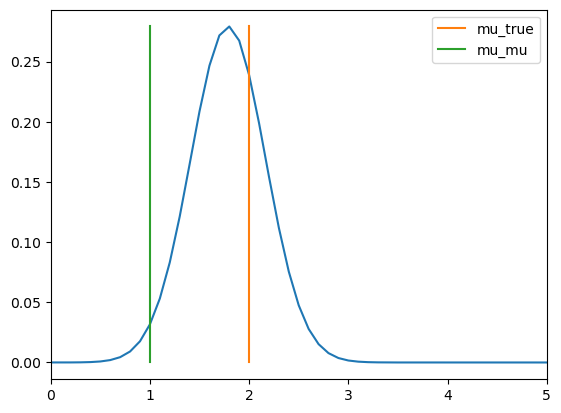

In [105]:
import matplotlib.pyplot as plt
import scipy

rng = np.random.default_rng(12345)
n = 2
d = 1

mu_true = 2
mu_mu = 1
cov_true = np.identity(d)

y_obs = rng.multivariate_normal(mean=np.array([mu_true]), cov=cov_true, size=n)

mu_val = np.arange(-10, 10, 0.1)

x0 = (y_obs.sum(axis=0) - mu_val) / (n - 1)
logp = -0.5 * (
    ((y_obs - x0) ** 2).sum(axis=0)
    + (x0 - mu_val) ** 2
    + (mu_val - mu_mu) ** 2
    + np.log(np.abs(1 - n) ** d)
    - ((y_obs - mu_true) ** 2).sum(axis=0)
) - d / 2 * np.log(2 * np.pi)
p = np.exp(logp)

P = scipy.integrate.simpson(p, x=mu_val)
print(P)

plt.plot(mu_val, p)
plt.plot([mu_true, mu_true + 1e-12], [p.min(), p.max()], label="mu_true")
plt.plot([mu_mu, mu_mu + 1e-12], [p.min(), p.max()], label="mu_mu")
plt.legend()
plt.xlim([0, 5])
plt.show()

/tmp/ipykernel_121135/3702793765.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logp[i] = model_logp.eval({'mu_param': [mu]}) -0.5*(x0 - mu)**2 + n*1.5#- logp_y


0.08993206321383226


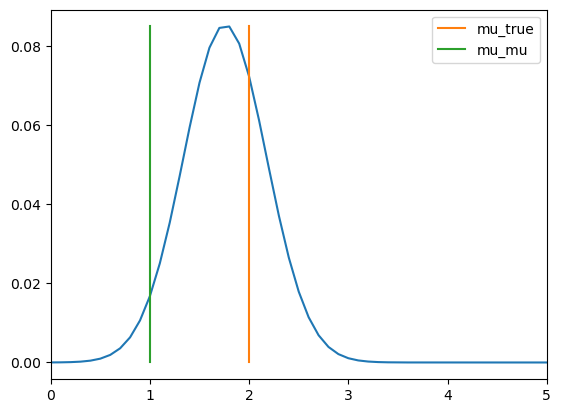

In [111]:
rng = np.random.default_rng(12345)
n = 2
d = 1

# Initialise arrays
mu_true = 2 * np.ones((d,))  # rng.random(d)
cov_true = np.identity(d)  # np.diag(rng.random(d))
Q_val = np.identity(d)  # np.diag(rng.random(d))
cov_param_val = np.identity(d)  # np.diag(rng.random(d))

# x_val = rng.random(d)
# mu_val = rng.random(d)

mu_mu = np.ones((d,))  # rng.random(d)
mu_cov = np.identity(d)  # np.diag(np.ones(d))
# cov_mu = rng.random(d**2)
# cov_cov = np.diag(np.ones(d**2))
# Q_mu = rng.random(d**2)
# Q_cov = np.diag(np.ones(d**2))

with pm.Model() as model:
    y_obs = rng.multivariate_normal(mean=mu_true, cov=cov_true, size=n)

    mu_param = pm.MvNormal("mu_param", mu=mu_mu, cov=mu_cov)
    # cov_param = np.abs(pm.MvNormal("cov_param", mu=cov_mu, cov=cov_cov))
    # Q = pm.MvNormal("Q", mu=Q_mu, cov=Q_cov)

    x = pm.MvNormal("x", mu=mu_param, tau=Q_val)

    y = pm.MvNormal(
        "y",
        mu=x,
        cov=cov_param_val,  # cov_param.reshape((d, d)),
        observed=y_obs,
    )

# pm.model_to_graphviz(model)
model_marg = marginalize(
    model,
    [x],
    Q=Q_val,
    temp_kwargs=[n, cov_param_val, y_obs, mu_true, model.rvs_to_values[mu_param]],
)
model_logp = model_marg.logp()

logp = np.zeros_like(mu_val)
logp_y = -0.5 * np.squeeze((y_obs - mu_true) ** 2).sum(axis=0) - d / 2 * np.log(2 * np.pi)
for i, mu in enumerate(mu_val):
    x0 = (y_obs.sum(axis=0) - mu) / (n - 1)
    logp[i] = model_logp.eval({"mu_param": [mu]}) - 0.5 * (x0 - mu) ** 2 + n * 1.5  # - logp_y

import matplotlib.pyplot as plt
import scipy

p = np.exp(logp)

P = scipy.integrate.simpson(p, x=mu_val)
print(P)

plt.plot(mu_val, p)
plt.plot([mu_true, mu_true + 1e-12], [p.min(), p.max()], label="mu_true")
plt.plot([mu_mu, mu_mu + 1e-12], [p.min(), p.max()], label="mu_mu")
plt.legend()
plt.xlim([0, 5])
plt.show()

In [40]:
rng = np.random.default_rng(12345)
n = 10000
d = 3

# Initialise arrays
mu_true = rng.random(d)
cov_true = np.diag(rng.random(d))
Q_val = np.diag(rng.random(d))
cov_param_val = np.diag(rng.random(d))

x_val = rng.random(d)
mu_val = rng.random(d)

mu_mu = rng.random(d)
mu_cov = np.diag(np.ones(d))
cov_mu = rng.random(d**2)
cov_cov = np.diag(np.ones(d**2))
Q_mu = rng.random(d**2)
Q_cov = np.diag(np.ones(d**2))

with pm.Model() as model:
    y_obs = rng.multivariate_normal(mean=mu_true, cov=cov_true, size=n)

    mu_param = pm.MvNormal("mu_param", mu=mu_mu, cov=mu_cov)
    # cov_param = np.abs(pm.MvNormal("cov_param", mu=cov_mu, cov=cov_cov))
    # Q = pm.MvNormal("Q", mu=Q_mu, cov=Q_cov)

    x = pm.MvNormal("x", mu=mu_param, tau=Q_val)

    y = pm.MvNormal(
        "y",
        mu=x,
        cov=cov_param_val,  # cov_param.reshape((d, d)),
        observed=y_obs,
    )

    # model.logp().dprint()

    # x0, log_likelihood = get_log_marginal_likelihood(
    #     x=model.rvs_to_values[x],
    #     Q=Q_val,#Q.reshape((d, d)),
    #     mu=mu_param,
    #     optimizer_kwargs={"tol": 1e-8},
    # )

    # print(model.free_RVs)

    # # with pm.Model() as inla_model:
    # log_prior = pm.logp(mu_param, mu_mu)
    # log_posterior = log_likelihood + log_prior
    # # # log_posterior.dprint()
    # # # log_posterior = pytensor.graph.replace.graph_replace(log_posterior, {model.rvs_to_values[x]: x0})
    # # # log_posterior_model = model_from_fgraph(log_posterior, mutate_fgraph=True)
    # # idata = pm.sample()
    # # draws = pm.draw(mu_param)
    # idata = pm.sample_prior_predictive()
    # print(idata.prior)
    # print(draws)

    # print(inla_model.free_RVs)
    # log_posterior.dprint()
    # pytensor.graph.fg.FunctionGraph(inputs=[model.rvs_to_values[mu_param], model.rvs_to_values[x]], outputs=[log_posterior])

# inla_model = marginalize(model, [mu_param, cov_param])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_param, Q, x]


Output()

ValueError: Not enough samples to build a trace.

True dataset:

$y \sim N(\mu_{true}, \Sigma_{true})$

Model:

$y|x, \sigma \sim N(Ax, \sigma W)$

Let $A=I$, $W=I$:

$y|x, \sigma \sim N(x, \sigma)$

Comparing model and true data:

$x = \mu_{true}$

$x|\theta \sim N(\mu, Q^{-1})$

$\theta = (\mu, \Sigma_b, \sigma)$

Set $Q = I$ for now.

$\theta = (\mu, \sigma)$

In [27]:
!python -m pytest -v /home/michaln/Michal_Linux/git/GSoC/pymc-extras/tests/test_inla.py

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "/home/michaln/Michal_Linux/git/GSoC/pymc-extras/.pixi/envs/default/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/home/michaln/Michal_Linux/git/GSoC/pymc-extras/.pixi/envs/default/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/michaln/Michal_Linux/git/GSoC/pymc-extras/.pixi/envs/default/lib/python3.12/importlib/__init__.py", line 130, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


============================= test session starts ==============================
platform linux -- Python 3.12.10, pytest-8.4.1, pluggy-1.6.0 -- /home/michaln/Michal_Linux/git/GSoC/pymc-extras/.pixi/envs/default/bin/python
cachedir: .pytest_cache
rootdir: /home/michaln/Michal_Linux/git/GSoC/pymc-extras
configfile: pyproject.toml
plugins: anyio-4.9.0
collected 1 item                                                               

../tests/test_inla.py::test_get_conditional_gaussian_approximation PASSED [100%]

============================== 1 passed in 5.99s ===============================
